<a href="https://colab.research.google.com/github/Sargam2808/Computer-Vision-project/blob/main/Dl_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LAB EXPERIMENT 5


Uploading Dataset

In [1]:
from google.colab import files
uploaded = files.upload()


Saving poems-100.pdf to poems-100.pdf


In [ ]:
Converting PDF TO TEXT

In [2]:
!pip install PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 69.0 MB/s eta 0:00:00


In [25]:
print("Total words:", len(tokens))
print("Unique words (Vocabulary size):", vocab_size)
print("Total poems (approx):", len(text_data.split("\n\n")))
print("Average words per poem:", len(tokens) // len(text_data.split("\n\n")))


Total words: 9492
Unique words (Vocabulary size): 2627
Total poems (approx): 1
Average words per poem: 9492


In [3]:
import fitz  # PyMuPDF

def pdf_to_text(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

# change filename if needed
text_data = pdf_to_text("poems-100.pdf")
print(text_data[:1000])


text
O my Luve's like 
That’s newly spru
O my Luve's like 
That’s sweetly pla
As fair art thou, m
So deep in luve a
And I will luve the
Till a’ the seas ga
Till a’ the seas ga
And the rocks me
I will luve thee sti
While the sands o
And fare thee we
And fare thee we
And I will come a
Tho’ it were ten th
The rose is red,
The violet's blue,
Sugar is sweet,
And so are you.
How do I love the
I love thee to the 
My soul can reac
For the ends of b
I love thee to the 
Most quiet need, 
I love thee freely,
I love thee purely
I love thee with th
In my old griefs, a
I love thee with a
With my lost sain
Smiles, tears, of 
I shall but love th
Had I the heaven
Enwrought with g
The blue and the
Of night and light
I would spread th
But I, being poor,
I have spread my
Tread softly beca
I.
    Enough! we're
    We sit beside t
    And wish that n
    The moss repr
    The hard types
    As heaven's sw
    With which we
II.
    You see we're 
    We dealt with b
    And in our own
    As if such colo
   

Importing Libraries

In [4]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
import time


Preprocessing

In [5]:
# clean text
text = text_data.lower()
text = re.sub(r"[^a-z\s]", "", text)
tokens = text.split()

print("Total words:", len(tokens))


Total words: 9492


In [6]:
# vocabulary
vocab = sorted(set(tokens))
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}
vocab_size = len(vocab)

print("Vocabulary size:", vocab_size)


Vocabulary size: 2627


RNN FROM SCRATCH(Numpy)

In [7]:
# Hyperparameters
hidden_size = 50
learning_rate = 0.01

Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(vocab_size, hidden_size) * 0.01
bh = np.zeros((hidden_size, 1))
by = np.zeros((vocab_size, 1))


In [8]:
def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

def one_hot(idx):
    vec = np.zeros((vocab_size, 1))
    vec[idx] = 1
    return vec


In [9]:
def forward(inputs, targets, hprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0

    for t in range(len(inputs)):
        xs[t] = one_hot(inputs[t])
        hs[t] = np.tanh(Wxh @ xs[t] + Whh @ hs[t-1] + bh)
        ys[t] = Why @ hs[t] + by
        ps[t] = softmax(ys[t])
        loss += -np.log(ps[t][targets[t], 0])
    return loss, hs[len(inputs)-1]


In [10]:
sample_input = [word2idx[tokens[i]] for i in range(5)]
sample_target = [word2idx[tokens[i+1]] for i in range(5)]

loss, _ = forward(sample_input, sample_target, np.zeros((hidden_size,1)))
print("Sample Loss:", loss)


Sample Loss: 39.36629474750301


ONE HOT ENCODING(Py-Torch)

In [11]:
seq_len = 5
X = []
Y = []

for i in range(len(tokens)-seq_len):
    X.append([word2idx[tokens[i+j]] for j in range(seq_len)])
    Y.append(word2idx[tokens[i+seq_len]])

X = torch.tensor(X)
Y = torch.tensor(Y)


Sample of tokenization

In [38]:
print("Original line:")
print(text_data.split("\n")[:3])

print("\nTokenized words:")
print(tokens[:8 ])

Original line:
['text', "O my Luve's like ", 'That’s newly spru']

Tokenized words:
['text', 'o', 'my', 'luves', 'like', 'thats', 'newly', 'spru']


RNN Model(One-Hot)

In [12]:
class RNN_OneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = nn.functional.one_hot(x, vocab_size).float()
        out, _ = self.rnn(x)
        out = self.fc(out[:,-1,:])
        return out


Training

In [13]:
model_oh = RNN_OneHot(vocab_size, 128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_oh.parameters(), lr=0.001)

losses_oh = []
start = time.time()

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model_oh(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    losses_oh.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

time_oh = time.time() - start


Epoch 1, Loss: 7.8924
Epoch 2, Loss: 7.8677
Epoch 3, Loss: 7.8430
Epoch 4, Loss: 7.8160
Epoch 5, Loss: 7.7847
Epoch 6, Loss: 7.7465
Epoch 7, Loss: 7.6985
Epoch 8, Loss: 7.6378
Epoch 9, Loss: 7.5613
Epoch 10, Loss: 7.4667


sample vector length

In [35]:
sample_word = tokens[15]
vec = torch.nn.functional.one_hot(
    torch.tensor(word2idx[sample_word]),
    vocab_size
)

print("Word:", sample_word)
print("One-hot vector length:", vec.shape[0])
print("Number of non-zero elements:", vec.sum().item())


Word: as
One-hot vector length: 2627
Number of non-zero elements: 1


Semnatic meaning example using one hot encoding(it fails to capture)

In [40]:
import torch

w1 = torch.nn.functional.one_hot(
    torch.tensor(word2idx["love"]),
    vocab_size
).float()

w2 = torch.nn.functional.one_hot(
    torch.tensor(word2idx["heart"]),
    vocab_size
).float()

cos_sim = torch.nn.functional.cosine_similarity(w1, w2, dim=0)
print("Cosine similarity between 'love' and 'heart' (One-Hot):", cos_sim.item())


Cosine similarity between 'love' and 'heart' (One-Hot): 0.0


One-Hot Loss Plot

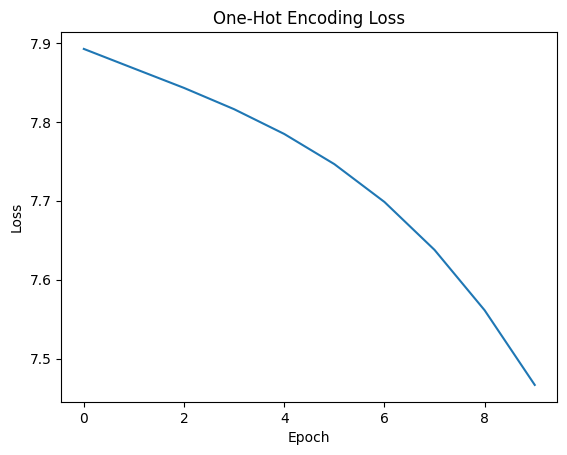

In [14]:
plt.plot(losses_oh)
plt.title("One-Hot Encoding Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Trainable Word embeddings

In [15]:
class RNN_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:,-1,:])
        return out


Training

In [16]:
model_emb = RNN_Embedding(vocab_size, 50, 128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emb.parameters(), lr=0.001)

losses_emb = []
start = time.time()

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model_emb(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    losses_emb.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

time_emb = time.time() - start


Epoch 1, Loss: 7.8926
Epoch 2, Loss: 7.8597
Epoch 3, Loss: 7.8265
Epoch 4, Loss: 7.7924
Epoch 5, Loss: 7.7563
Epoch 6, Loss: 7.7172
Epoch 7, Loss: 7.6735
Epoch 8, Loss: 7.6235
Epoch 9, Loss: 7.5651
Epoch 10, Loss: 7.4958


In [34]:
print("Sample word to index mapping:")
for w in list(word2idx.keys())[:10]:
    print(f"{w} -> {word2idx[w]}")


Sample word to index mapping:
a -> 0
ab -> 1
about -> 2
above -> 3
abruptly -> 4
absorbing -> 5
abundan -> 6
abuttoning -> 7
ac -> 8
accept -> 9


Example of Semantic menaing using embeddings

In [39]:
import torch.nn.functional as F

def semantic_similarity(word, topk=5):
    idx = word2idx[word]
    vec = model_emb.embed.weight[idx]
    similarity = F.cosine_similarity(
        vec.unsqueeze(0),
        model_emb.embed.weight
    )
    top_indices = torch.topk(similarity, topk+1).indices.tolist()
    return [idx2word[i] for i in top_indices if i != idx][:topk]

print("Words semantically similar to 'love':")
print(semantic_similarity("love"))

print("\nWords semantically similar to 'night':")
print(semantic_similarity("night"))


Words semantically similar to 'love':
['mossy', 'logic', 'eve', 'patiently', 'ab']

Words semantically similar to 'night':
['pay', 'promis', 'well', 'br', 'flash']


In [41]:
v1 = model_emb.embed.weight[word2idx["love"]]
v2 = model_emb.embed.weight[word2idx["heart"]]

cos_sim = torch.nn.functional.cosine_similarity(v1, v2, dim=0)
print("Cosine similarity between 'love' and 'heart' (Embedding):", cos_sim.item())


Cosine similarity between 'love' and 'heart' (Embedding): 0.13825297355651855


Embedding Loss Plot

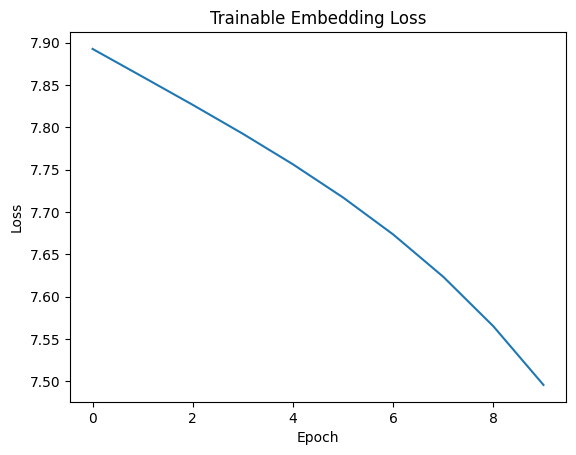

In [17]:
plt.plot(losses_emb)
plt.title("Trainable Embedding Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Text Generation

In [42]:
def generate_text_verbose(model, start_word, length=10):
    model.eval()
    word = start_word
    print("Start word:", word)

    for i in range(length):
        x = torch.tensor([[word2idx[word]]])
        out = model(x)
        probs = torch.softmax(out, dim=1)

        next_idx = torch.argmax(probs).item()
        next_word = idx2word[next_idx]

        print(f"Step {i+1}: '{word}' → '{next_word}'")
        word = next_word


In [50]:
print("Embedding model generation steps:")
generate_text_verbose(model_emb, "love")


Embedding model generation steps:
Start word: love
Step 1: 'love' → 'musing'
Step 2: 'musing' → 'sum'
Step 3: 'sum' → 'fro'
Step 4: 'fro' → 'onc'
Step 5: 'onc' → 'bloo'
Step 6: 'bloo' → 'youth'
Step 7: 'youth' → 'hollow'
Step 8: 'hollow' → 'sparkles'
Step 9: 'sparkles' → 'scratch'
Step 10: 'scratch' → 'words'


In [45]:
print("Embedding model generation steps:")
generate_text_verbose(model_oh, "love")

Embedding model generation steps:
Start word: love
Step 1: 'love' → 'three'
Step 2: 'three' → 'have'
Step 3: 'have' → 'h'
Step 4: 'h' → 'would'
Step 5: 'would' → 'have'
Step 6: 'have' → 'h'
Step 7: 'h' → 'would'
Step 8: 'would' → 'have'
Step 9: 'have' → 'h'
Step 10: 'h' → 'would'


Comparing no. of parameters

In [36]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("One-Hot RNN Parameters:", count_params(model_oh))
print("Embedding RNN Parameters:", count_params(model_emb))


One-Hot RNN Parameters: 691779
Embedding RNN Parameters: 493273


COMPARISON

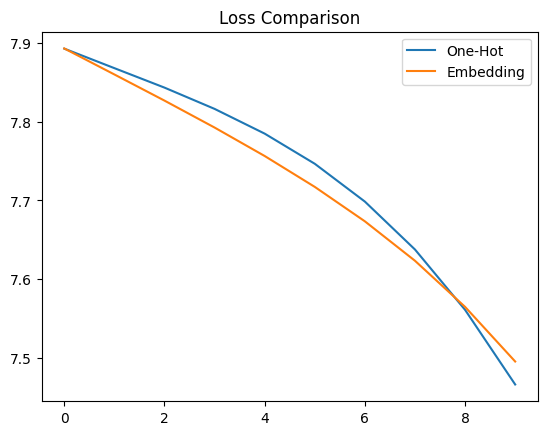

In [20]:
plt.plot(losses_oh, label="One-Hot")
plt.plot(losses_emb, label="Embedding")
plt.legend()
plt.title("Loss Comparison")
plt.show()


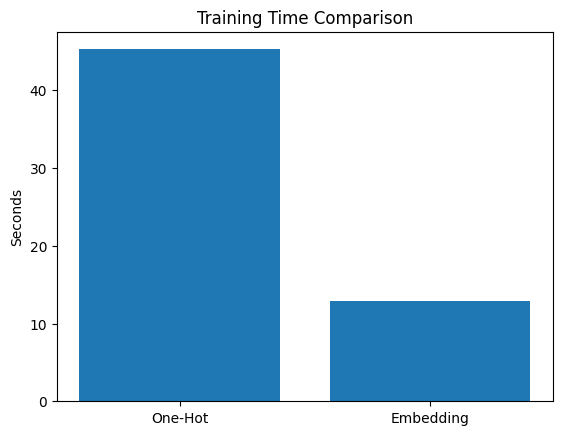

In [21]:
plt.bar(["One-Hot", "Embedding"], [time_oh, time_emb])
plt.ylabel("Seconds")
plt.title("Training Time Comparison")
plt.show()
